Step 0:


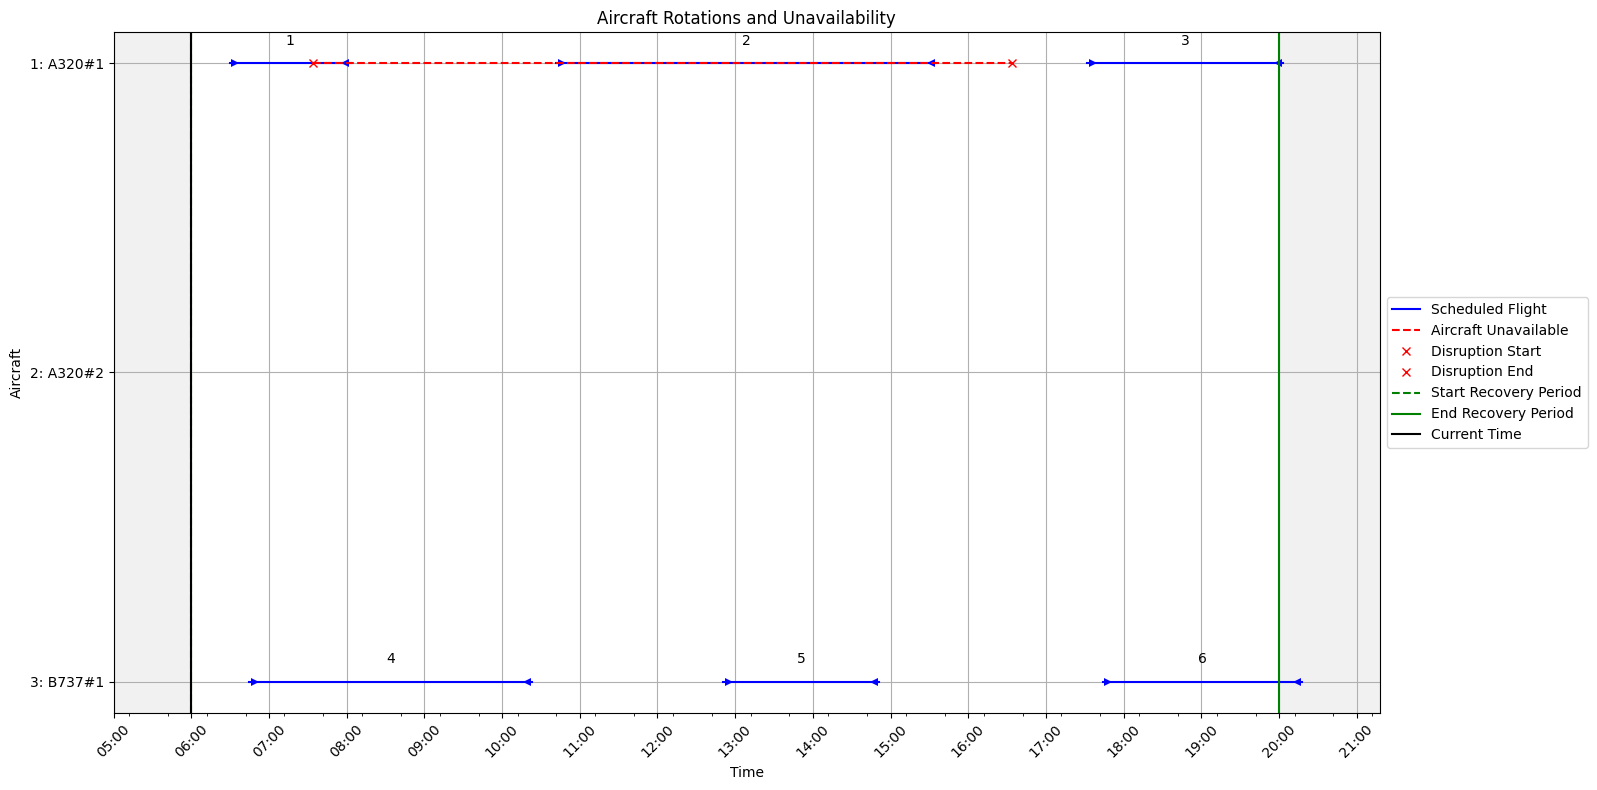

Action taken: 2, Reward: 1000
Step 1:


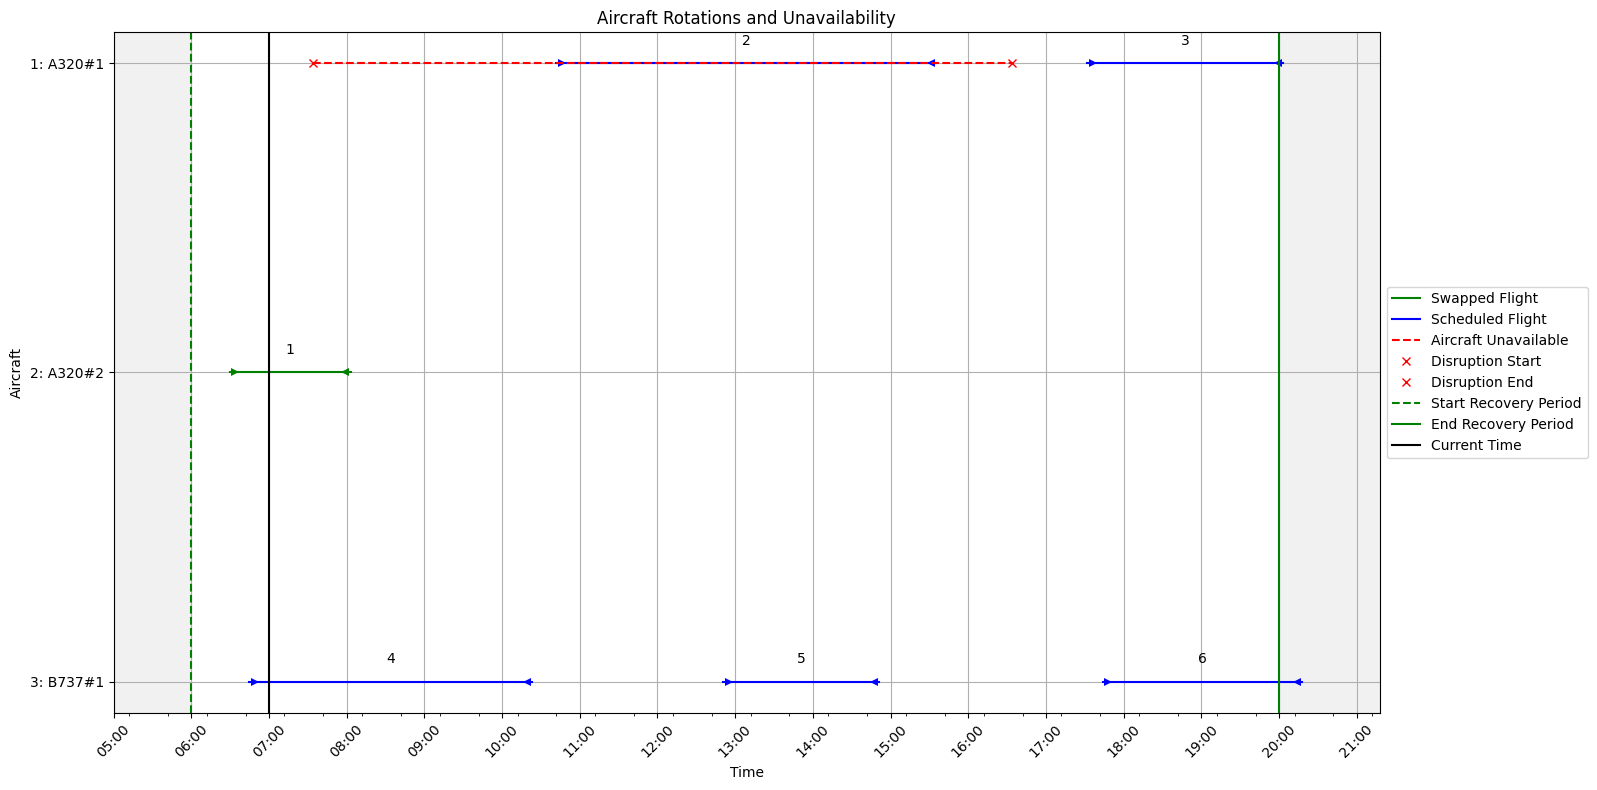

Action taken: 2, Reward: 1000
Final state:


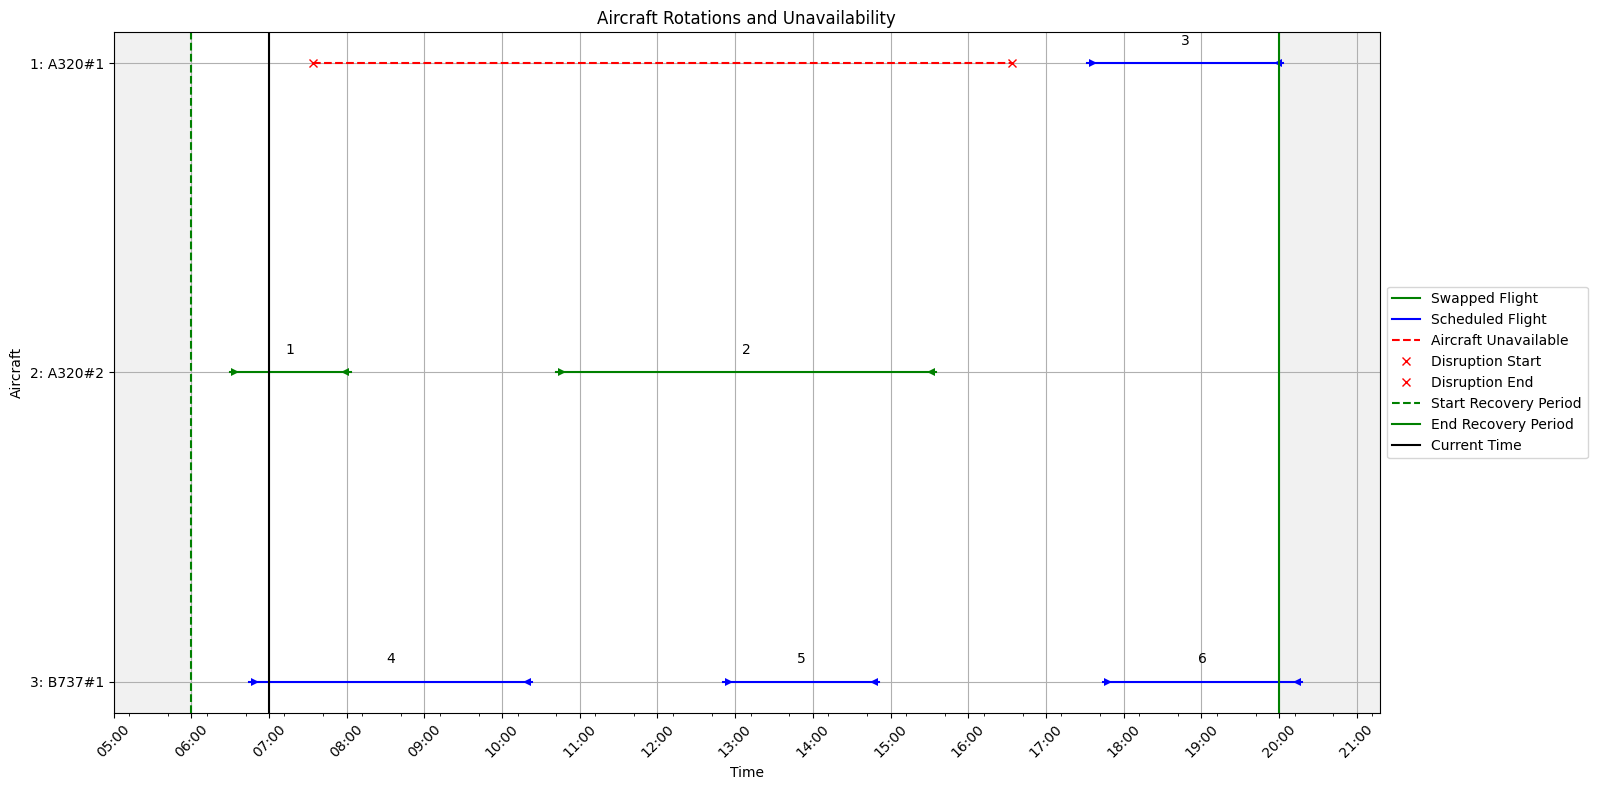

Total Reward: 2000
Total Steps: 2


(2000, 2)

In [27]:
import os
import torch as th
import numpy as np
import gymnasium as gym
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter

# Load the model and run inference
def run_inference(model_path, scenario_folder):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, 
        flights_dict, 
        rotations_dict, 
        alt_aircraft_dict, 
        config_dict
    )

    # Load the trained model and set the environment
    model = DQN.load(model_path)
    model.set_env(env)

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=aircraft_dict, 
        flights_dict=flights_dict, 
        rotations_dict=rotations_dict, 
        alt_aircraft_dict=alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime
    )

    # Reset the environment for inference
    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000  # Set a maximum number of steps to prevent infinite loops

    while not done_flag and step_num < max_steps:
        # Visualize the current state
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.swapped_flights
        environment_delayed_flights = env.environment_delayed_flights
        current_datetime = env.current_datetime
        updated_flights_dict = env.flights_dict
        cancelled_flights = env.penalized_cancelled_flights

        # Plot the current state
        state_plotter.plot_state(
            updated_flights_dict, 
            swapped_flights, 
            environment_delayed_flights, 
            cancelled_flights, 
            current_datetime
        )

        # Use the trained model to predict the action
        action, _ = model.predict(obs, deterministic=True)

        # Take action in the environment
        obs, reward, terminated, truncated, info = env.step(action)

        # Accumulate the reward
        total_reward += reward

        print(f"Action taken: {action}, Reward: {reward}")

        # Combine terminated and truncated flags
        done_flag = terminated or truncated

        step_num += 1


    print("================================================")
    print("Final state:")
    # Plot final state
    state_plotter.plot_state(
        updated_flights_dict, 
        swapped_flights, 
        environment_delayed_flights, 
        cancelled_flights, 
        current_datetime
    )

    if DEBUG_MODE_PRINT_STATE:
        print_state_nicely(env.state)


    print(f"Total Reward: {total_reward}")
    print(f"Total Steps: {step_num}")

    return total_reward, step_num

# Specify the model path and the scenario folder you want to inference
MODEL_PATH = "../trained_models/1k-3ac-12f-1dis-F-5M-2.zip"

# SCENARIO_FOLDER = "../data/Training-1k-small-full/Scenario_01" # Training set
# SCENARIO_FOLDER = "../data/Example/PoC-scenario" # Example set
# SCENARIO_FOLDER = "../data/Testing/1k-3ac-12f-1dis-F/Scenario_06"
SCENARIO_FOLDER = "../data/Testing/10-3ac-12f-1dis-T/Scenario_01"


# Verify folder and model exist
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# Run inference
run_inference(MODEL_PATH, SCENARIO_FOLDER)
